### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [2]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-17 09:31:42--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.02s   

2025-09-17 09:31:42 (5.47 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [3]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [4]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [5]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [6]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [7]:
train_data = data_monthly[:-24]
test_data = data_monthly[-24:]

In [8]:
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

trend_types = ['add', 'mul', None]
seasonal_types = ['add', 'mul', None]
damped_options = [True, False]
seasonal_periods = 12

best_rmse = float('inf')
best_config = None
best_model = None
best_predictions = None

for trend in trend_types:
  for seasonal in seasonal_types:
    for damped in damped_options:
      if seasonal is not None and seasonal_periods is None:
        continue

      try:
        model = ExponentialSmoothing(train_data,
                                     trend=trend,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods if seasonal is not None else None,
                                     damped_trend=damped).fit()

        predictions = model.forecast(steps=len(test_data))

        current_rmse = rmse(test_data, predictions)
        if current_rmse < best_rmse:
          best_rmse = current_rmse
          best_config = {'trend': trend, 'seasonal': seasonal, 'damped': damped, 'seasonal_periods': seasonal_periods if seasonal is not None else None}
          best_model = model
          best_predictions = predictions

      except Exception as e:
        print(f"Could not fit model with config: trend={trend}, seasonal={seasonal}, damped={damped}. Error: {e}")
        continue

print(best_config)
print(best_rmse)

Could not fit model with config: trend=None, seasonal=add, damped=True. Error: Can only dampen the trend component
Could not fit model with config: trend=None, seasonal=mul, damped=True. Error: Can only dampen the trend component
Could not fit model with config: trend=None, seasonal=None, damped=True. Error: Can only dampen the trend component
{'trend': 'mul', 'seasonal': 'add', 'damped': True, 'seasonal_periods': 12}
0.8958522762071295


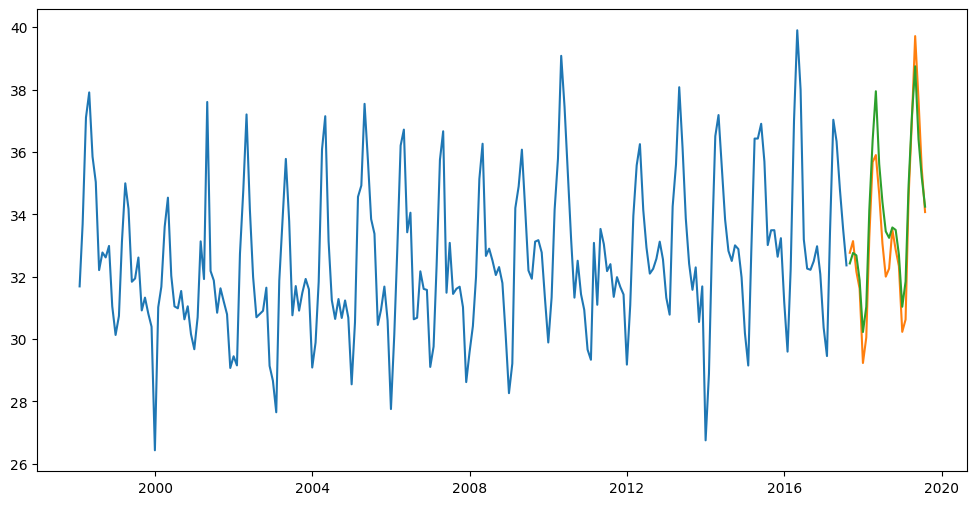

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(best_predictions.index, best_predictions)

